In [76]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import sys

from scipy.stats import multivariate_normal

# Part 1

In [60]:
def ldaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix
    
    # N: training examples
    # d: features
    # k: classes
    
    N, d = X.shape
    unique_classes = np.unique(y) # grab each unique value
    k = unique_classes.size
    
    _means = []
    for uc in unique_classes:
        is_class = (y == uc).reshape(y.shape[0], ) # condition-matrix where y is the class
        from_class = X[is_class]                   # grab from X where y is the class
        class_means = np.mean(from_class, axis=0)  # get the means for each column (d columns)
        _means.append(class_means)

    means = np.array(_means).T # reshape means to be d x k (versus k x d)
    
    covmat = np.cov(X.T)
    
    return means,covmat

In [61]:
def ldaTest(means,covmat,Xtest,ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    res = np.zeros(len(ytest))
    for i, x in enumerate(Xtest):
        y = ytest[i]
        values = []
        for mean in means.T:
            values.append(multivariate_normal.pdf(x, mean, covmat))

        res[i] = np.argmax(np.array(values)) + 1 # we add one to match index
        
    acc = sum(res - ytest.reshape(len(ytest), ) == 0)/len(res)
            
    return acc, np.array(res).reshape(ytest.shape)

In [66]:
def qdaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes

    N, d = X.shape
    unique_classes = np.unique(y) # grab each unique value
    k = unique_classes.size
    
    _means = []
    covmats = []
    for uc in unique_classes:
        is_class = (y == uc).reshape(y.shape[0], ) # condition-matrix where y is the class
        from_class = X[is_class]                   # grab from X where y is the class
        class_means = np.mean(from_class, axis=0)  # get the means for each column (d columns)
        _means.append(class_means)
        
        covmat = np.cov(from_class.T)
        covmats.append(covmat)

    means = np.array(_means).T # reshape means to be d x k (versus k x d)
    
    return means,covmats

In [67]:
def qdaTest(means,covmats,Xtest,ytest):
    # Inputs
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    res = np.zeros(len(ytest))
    for i, x in enumerate(Xtest):
        y = ytest[i]
        values = []
        for j in range(len(means.T)):
            mean = means.T[j]
            covmat = covmats[j]
            values.append(multivariate_normal.pdf(x, mean, covmat))

        res[i] = np.argmax(np.array(values)) + 1 # we add one to match index
        
    acc = sum(res - ytest.reshape(len(ytest), ) == 0)/len(res)
            
    return acc, np.array(res).reshape(ytest.shape)

LDA Accuracy = 0.97
QDA Accuracy = 0.96


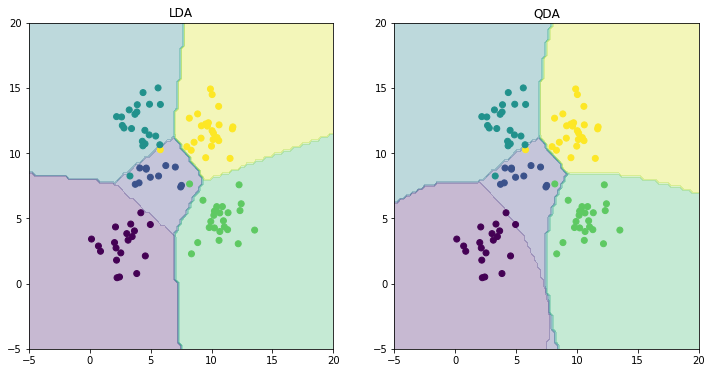

In [74]:
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')

#LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))

# QDA
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))

# plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.reshape(ytest.size, ))
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.reshape(ytest.size, ))
plt.title('QDA')

plt.show()

# Part 2

In [207]:
def learnOLERegression(X,y):
    # Inputs:
    # X = N x d
    # y = N x 1
    # Output:
    # w = d x 1

    return np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

def testOLERegression(w,Xtest,ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    # mse

    N = float(Xtest.shape[0])
    return (1/N) * np.dot((ytest - np.dot(Xtest, w)).T, (ytest - np.dot(Xtest, w)))[0,0]

Functions Agree: True
(solid red line and green dotted line should match)


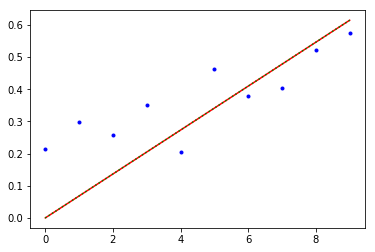

MSE (these should all be the same):

0.016172779462871784
0.01617277946287178
0.016172779462871777


In [215]:
# Testing our learnOLERegression versus Numpy's

# Generate Data
count = 10
x_test = np.arange(count).astype(float).reshape(count, 1)
y_test = np.zeros_like(x_test).astype(float)
for i, x in enumerate(x_test):
    y_test[i] = np.random.rand()/4 + x/20
    
plt.plot(x_test, y_test, 'b.')

# Use Numpy's function
z,resid,rank,sigma = np.linalg.lstsq(x_test, y_test, rcond=None)
y_lib = np.zeros_like(x_test).astype(float)
for i, x in enumerate(x_test):
    y_lib[i] = x*z
    
plt.plot(x_test, y_lib, 'r-')

# User our function
w = learnOLERegression(x_test,y_test)
y_our = np.zeros_like(x_test).astype(float)
for i, x in enumerate(x_test):
    y_our[i] = x*w
    
plt.plot(x_test, y_our, 'g:')

in_agreeance = np.allclose(y_our, y_lib)
print("Functions Agree:", in_agreeance)
if in_agreeance:
    print("(solid red line and green dotted line should match)")
plt.show()

print("MSE (these should all be the same):\n")
print(((y_lib - y_test)**2).mean()) # simple implimintation
print(((y_our - y_test)**2).mean())
print(testOLERegression(w,x_test,y_test))

In [214]:
# Problem 2
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'),encoding = 'latin1')

# add intercept
X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)

w = learnOLERegression(X,y)
mle = testOLERegression(w,Xtest,ytest)

w_i = learnOLERegression(X_i,y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)

print('MSE without intercept '+str(mle))
print('MSE with intercept '+str(mle_i))

MSE without intercept 106775.36155730896
MSE with intercept 3707.8401815996954


# Problem 3

In [228]:
def learnRidgeRegression(X,y,lambd):
    # Inputs:
    # X = N x d
    # y = N x 1
    # lambd = ridge parameter (scalar)
    # Output:
    # w = d x 1

    return np.dot(np.linalg.inv(np.dot(X.T, X) + lambd*np.identity(X.shape[1])), np.dot(X.T, y))

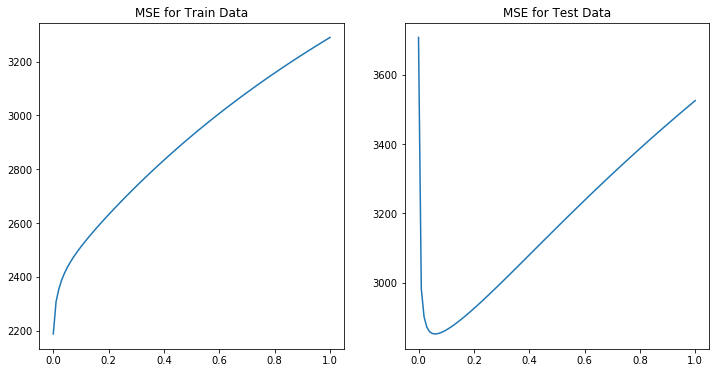

In [364]:
# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k,1))
mses3 = np.zeros((k,1))
for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    mses3_train[i] = testOLERegression(w_l,X_i,y)
    mses3[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')

plt.show()

# Problem 4

In [367]:
def regressionObjVal(w, X, y, lambd):

    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda
    
    N = float(Xtest.shape[0])
    resid = np.squeeze((np.dot(X, np.expand_dims(w, 1)) - y))
    error = np.sum(resid.T*resid)/N
    error_grad = np.dot(X.T, resid)  + lambd*w
    error_grad /= N
    
    return error, error_grad

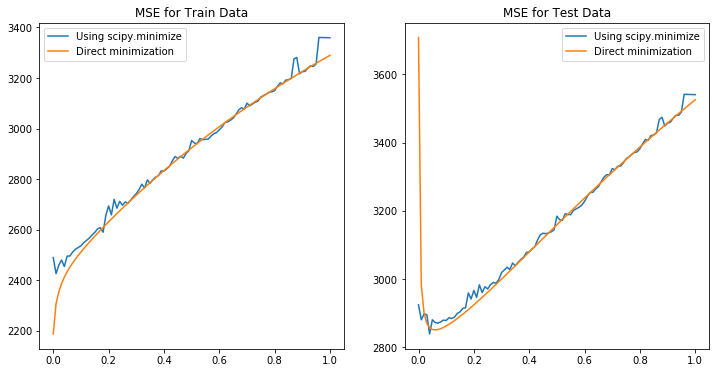

In [373]:
# Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 20}    # Preferred value.
w_init = np.ones((X_i.shape[1],1))
for lambd in lambdas:
    args = (X_i, y, lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses4_train)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize','Direct minimization'])

plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.show()

# Problem 5

In [436]:
def mapNonLinear(x,p):
    # Inputs:
    # x - a single column vector (N x 1)
    # p - integer (>= 0)
    # Outputs:
    # Xp - (N x (p+1))

    N = x.shape[0]
    Xp = np.zeros((N, p+1))
    for deg in range(p+1):
        Xp[:,deg] = x ** deg
    return Xp

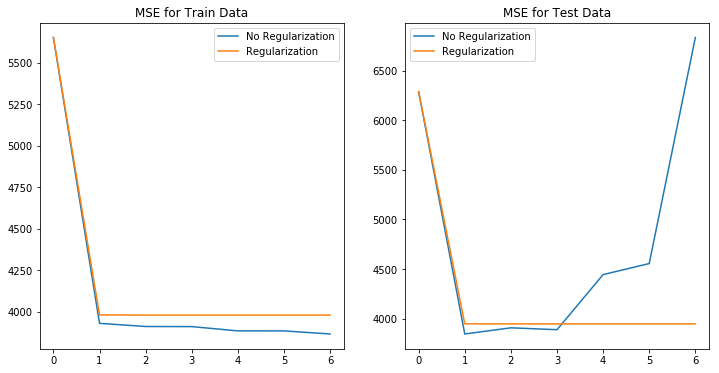

In [438]:
pmax = 7
lambda_opt = 0.1 # REPLACE THIS WITH lambda_opt estimated from Problem 3
mses5_train = np.zeros((pmax,2))
mses5 = np.zeros((pmax,2))
for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    w_d1 = learnRidgeRegression(Xd,y,0)
    mses5_train[p,0] = testOLERegression(w_d1,Xd,y)
    mses5[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    w_d2 = learnRidgeRegression(Xd,y,lambda_opt)
    mses5_train[p,1] = testOLERegression(w_d2,Xd,y)
    mses5[p,1] = testOLERegression(w_d2,Xdtest,ytest)

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax),mses5_train)
plt.title('MSE for Train Data')
plt.legend(('No Regularization','Regularization'))
plt.subplot(1, 2, 2)
plt.plot(range(pmax),mses5)
plt.title('MSE for Test Data')
plt.legend(('No Regularization','Regularization'))
plt.show()